In [1]:
## To Do


# Should data be log normalised following a +1/ This will remove negative values after log norm.

In [2]:
writeOutput = False
writeOutput = True


# Define functions

In [3]:
import os
import scipy
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt

from openpyxl import load_workbook

from scipy import stats as stats
from copy import copy as copy

from IPython.display import clear_output

import time

In [4]:
titleFont = {'fontsize': 32}
# ,
#  'fontweight': rcParams['axes.titleweight'],
#  'color': rcParams['axes.titlecolor'],
#  'verticalalignment': 'baseline',
#  'horizontalalignment': loc}

labelFont = {'fontsize': 20}
# ,
#  'fontweight': rcParams['axes.titleweight'],
#  'color': rcParams['axes.titlecolor'],
#  'verticalalignment': 'baseline',
#  'horizontalalignment': loc}



In [5]:
colourList = [
    (230, 159,   0, 1),
    ( 86, 180, 233, 1),
    (  0, 158, 115, 1),
    (240, 228,  66, 1),
    (  0, 114, 178, 1),
    (213,  94,   0, 1),
    (204, 121, 167, 1),
    (  0,   0,   0, 1)]

colourList = [
    (0.90, 0.60, 0.00, 1),
    (0.35, 0.70, 0.90, 1),
    (0.00, 0.60, 0.50, 1),
    (0.95, 0.90, 0.25, 1),
    (0.00, 0.45, 0.70, 1),
    (0.80, 0.40, 0.00, 1),
    (0.80, 0.60, 0.70, 1),
    (  0,   0,   0, 1)]


# namedColourList = ['orange','skyblue','seagreen','yellow','blue','indianred','violet','black']
namedColourList = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [6]:
class master_data:
    def __init__(self, dataPath):
        ### import data from excel workbook
        
        self.wb = load_workbook(dataPath)
        self.ws = self.wb['Exported dataset']
        self.values = [[y.value for y in x] for x in self.ws[self.ws.calculate_dimension()]]

        self.dropData = False
        
        
        ### Convert nested list to a pandas dataFrame and extract expression data with labels
    def get_data(self):
        df = pd.DataFrame(self.values)
        col3 = df.iloc[:,3].tolist()
        self.targIdx = col3.index('Target name (display name)') + 1

        
        rowLabels = df.iloc[self.targIdx:,3]
        # rowLabels = [x.split(' (')[0] for x in rowLabels.values]
        rowLabels = dict(zip([x for x in range(self.targIdx,self.targIdx+len(rowLabels))],rowLabels))
        rowLabels

        colLabels = df.iloc[0,4:]
        colLabels = [x.replace(' | ','_') for x in colLabels.values]
        colLabels = dict(zip([x for x in range(4,4+len(colLabels))],colLabels))
        colLabels

        self.data = df.iloc[self.targIdx:,4:].astype(np.float32)
        self.data.rename(index=rowLabels,columns=colLabels, inplace=True)

        
        self.sampleInfo = pd.DataFrame(df.iloc[0:self.targIdx-1,4:])
        self.sampleInfo.rename(index=df.iloc[0:self.targIdx-1,0], columns=colLabels, inplace=True)
        print('sampleInfo.shape')
        print(self.sampleInfo.shape)
        
        
        print('data.shape')
        print(self.data.shape)

        self.dataOrig = self.data.copy()
        # Log transform data for QC and analysis steps
        self.dataLog1 = np.log2(self.data+1)
        
        
        self.probeClass = df.iloc[self.targIdx:,2]      ### Index needs updating here also
        self.probeClass.rename(index=rowLabels, inplace=True)
        self.probeClass.rename(index='ProbeClass', inplace=True)
        self.probeClassDict = {
            'Positive': 'A',
            'Negative': 'B',
            'Control': 'C',
            'Endogenous': 'E'
        }
        return self.dataLog1.copy(), self.sampleInfo.copy()
    
    def get_descriptors(self):
        ### Extract descriptions for each sample
        nuclei = sampleInfo.loc['AOI nuclei count']
        surfArea = sampleInfo.loc['AOI surface area']

        print(sampleInfo.shape)
#         sampleInfo
        
    def add_class_mean(self, df):
        ## Add column to data with mean values for each probe (row)
        mean = df.mean(axis = 1)
        df = df.assign(mean=mean.values)

        ## Add column to data with probe class for each probe
        df = df.assign(probeClass=[self.probeClassDict[v] for v in self.probeClass.values])

        ### Extract lists of controls and their values
        self.posCTLs = self.probeClass.index[self.probeClass== 'Positive'].tolist()
        self.negCTLs = self.probeClass.index[self.probeClass== 'Negative'].tolist()
        self.IgCTLs = copy(self.negCTLs)
        try:
            self.IgCTLs.remove('HYB-NEG')
        except ValueError:
            pass
        self.HK = self.probeClass.index[self.probeClass== 'Control'].tolist()
        self.endog = self.probeClass.index[self.probeClass== 'Endogenous'].tolist()

        print('Positive Control count:\t{:d}, {}'.format(len(self.posCTLs), self.posCTLs))
        print('Nagative Control count:\t{:d}, {}'.format(len(self.negCTLs), self.negCTLs))
        print('Ig Control count:\t{:d}, {}'.format(len(self.IgCTLs), self.IgCTLs))
        print('HK Control count:\t{:d}, {}'.format(len(self.HK), self.HK))
        print('Endogenous probe count:\t{:d}, {}'.format(len(self.endog), self.endog))

        return df.copy(), self.sampleInfo.copy()

    def drop_AOIs(self, includes, writeOrig=False):
        dropAOIs = [x for x in list(self.data.columns) if includes in x]
        self.dataLog1.drop(labels=dropAOIs, axis=1, inplace=True)
        
        if writeOrig:
            self.dataOrig = self.dataOrig.drop(labels=dropAOIs, axis=1, inplace=True)
        
        self.sampleInfo = self.sampleInfo.drop(labels=dropAOIs, axis=1)
        
        
        return self.dataLog1.copy(), self.sampleInfo.copy()
        
    def set_threshold(self, threshold):
        self.threshold = threshold
        
        
        # ToDo: Check that all values in master data are also included in threshold dataFrame
        # ToDo: Convert threshold data to 0/1 data if needed
        
    
#     def drop_sample(self):
#         try:
#             assert type(labels) == list
#         except:
#             print('labels need to be a list')
#             return False

#         if not self.dropData:
#             self,.dropData = self.dataLog1
            
#         self.dropData.drop((labels=labels, axis=1))
#         return self.dropData
        
    def drop_probes(self, labels):
        try:
            assert type(labels) == list
        except:
            print('labels need to be a list')
            return False
            
        if not self.dropData:
            self.dropData = self.dataLog1

        self.dropData.drop(labels=labels)
        
        return self.dropData.copy()
        
    def ERCC_norm(self):
        if not self.dropData:
            self.dropData = self.dataLog1
            
        try:
            self.dropData = self.dropData.drop(labels=['mean'], axis=1)
        except:
            pass
        try:
            self.dropData = self.dropData.drop(labels=['probeClass'], axis=1)
        except:
            pass
            
            
        # ERCC normalisation. 
        # Divide by individual HYB-POS values, then scale data using the geometric mean of all HYB-POS values. subtract in log space is same as divide in normal space. Add in log space is same as multiply in normal space
        self.ERCCData = self.dropData - self.dropData.loc['HYB-POS'] + np.mean(self.dropData.loc['HYB-POS'])

        #ToDo: set below threshold values to 0
        self.ERCCData = self.ERCCData * self.threshold
        
        #set any negative values following ERCC noirmalisation to 0. These are at or below the limit of detection
#         zeroFilter = self.ERCCData > 0
        
        self.ERCCData = self.ERCCData * (self.ERCCData>0)
        
        return self.ERCCData.copy()
        


In [7]:
def plot_SA_Hist(surfArea):
    
        
    fig, ax = plt.subplots(figsize=(10,5))
    ax.hist(surfArea, bins=50)


    ax.set_xlabel('AOI Surface Area µm', fontdict=labelFont)
    ax.set_ylabel('Count', fontdict=labelFont)
    ax.set_title('AOI Surface Area distribution', fontdict=titleFont)

    print('Min SA')
    print(min(surfArea))

    print('Max SA')
    print(max(surfArea))
    
    return(fig)



In [8]:
# # Plot log2 transformed raw data before any normalisation

# def draw_probe_plot(dataRaw, dataSortedRaw, namedColourList, title, exp=False, violin=False):
    
#     fig, ax = plt.subplots(figsize=(15,8))
    
#     if exp:
#         ax.boxplot(np.exp2(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T) -1, sym='-', labels=dataSortedRaw.index)
#     else:
#         ax.boxplot(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T, sym='-', labels=dataSortedRaw.index)

    
#     if violin:
#         if exp:
#             ax.violinplot(np.exp2(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T) -1)

#     #         ax.boxplot(np.exp2(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T) -1, sym='-', labels=dataSortedRaw.index)
#         else:
#             ax.violinplot(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T)

#     #         ax.boxplot(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T, sym='-', labels=dataSortedRaw.index)
        
        
#     else:


#         for i,j in enumerate(dataSortedRaw.index):
#             y = dataRaw.drop(labels=['mean','probeClass'], axis=1).loc[j]
#             colours = [namedColourList[2] if v.split('_')[-1] == 'Tumour' else namedColourList[5] if v.split('_')[-1] == 'TME' else namedColourList[1] for v in y.index]
#         #     colours = [colourList[2] if v.split('_')[-1] == 'Tumour' else colourList[5] if v.split('_')[-1] == 'Immune' else colourList[1] for v in y.index]
#             y = y
#             if exp:
#                 y = np.exp2(y.values)-1
#             else:
#                 y = y.values

#             x = np.random.normal(i+1, 0.1, len(y))

#             for i in range(len(x)): 
#                 ax.plot(x[i], y[i], c=colours[i], marker='.', alpha=0.25)

#     ax.set_xticks(np.arange(1,len(dataSortedRaw.index)+1,1))
#     ax.set_xlabel=list(dataSortedRaw.index)
    
#     print(len(np.arange(0,len(dataSortedRaw.index),1)))
#     print(len(list(dataSortedRaw.index)))
    
#     ax.tick_params(axis='x', labelrotation = 90)
    

#     if exp:
#         ax.semilogy()
#         ax.set_title(title + ' (untransformed)', size=36)
#         ax.set_ylabel('Probe value', size=24)
#     else:
#         ax.set_title(title + ' (Log2 transformed)', size=36)
#         ax.set_ylabel('Log2 probe value', size=24)
# #     plt.show()
    
#     return(fig)


In [9]:
# dataSortedRaw = dataLog1External.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])

# probePlot = draw_probe_plot_2(dataLog1External, dataSortedRaw, namedColourList, sampleInfoExternal, selectedInfo, 'Col', 'Raw Probe Values')


In [10]:
# Plot log2 transformed raw data before any normalisation
def draw_probe_plot_2(dataRaw, dataSortedRaw, namedColourList, sampleInfoExternal, selectedInfo, subSelection=None, title='Title', exp=False, violin=False):

    if not (subSelection == None):
        selectedInfo = selectedInfo.loc[subSelection]
    if (type(selectedInfo) == pd.core.series.Series):
        selectedInfo = pd.DataFrame(selectedInfo).T
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    if exp:
        ax.boxplot(np.exp2(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T) -1, sym='-', labels=dataSortedRaw.index)
    else:
        ax.boxplot(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T, sym='-', labels=dataSortedRaw.index)

    if violin:
        if exp:
            ax.violinplot(np.exp2(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T) -1)
        else:
            ax.violinplot(dataRaw.drop(labels=['mean','probeClass'], axis=1).reindex(labels=dataSortedRaw.index).T)
    else:
        sampleInfoExternal, my_cmap, colours = get_colour_mapping(sampleInfoExternal, selectedInfo)
        my_cmap = plt.get_cmap("nipy_spectral")(colours)
        for i,j in enumerate(dataSortedRaw.index):
            y = dataRaw.drop(labels=['mean','probeClass'], axis=1).loc[j]
            y = y
            if exp:
                y = np.exp2(y.values)-1
            else:
                y = y.values
            x = np.random.normal(i+1, 0.1, len(y))
            for i in range(len(x)): 
                # ax.plot(x[i], y[i], color=my_cmap[i], marker='.', alpha=0.25)
                ax.plot(x[i], y[i], color=my_cmap[i], marker='.')#

    ax.set_xticks(np.arange(1,len(dataSortedRaw.index)+1,1))
    ax.set_xlabel=list(dataSortedRaw.index)
    # print(len(np.arange(0,len(dataSortedRaw.index),1)))
    # print(len(list(dataSortedRaw.index)))
    ax.tick_params(axis='x', labelrotation = 90)

    if exp:
        ax.semilogy()
        ax.set_title(title + ' (untransformed)', size=36)
        ax.set_ylabel('Probe value', size=24)
    else:
        ax.set_title(title + ' (Log2 transformed)', size=36)
        ax.set_ylabel('Log2 probe value', size=24)
#     plt.show()
    
    return(fig)


In [11]:
def probe_GeoMean_Plots(plotData, title=''):
    rows=1
    cols=2
    colours = [namedColourList[2] if x.split('_')[-1] == 'Tumour' else namedColourList[5] if x.split('_')[-1] == 'TME' else namedColourList[1] for x in HKGeoMean.index]

    fig,ax = plt.subplots(rows,cols, sharey=True, gridspec_kw={'width_ratios': [4,1]}, figsize=(15,5))
    ax[0].bar(np.linspace(1,len(plotData),len(plotData)), plotData, color=colours)
    ax[1].hist(plotData, bins=int(len(plotData)/10),orientation='horizontal', color='k')
    ax[0].set_xlim(0,len(plotData))
    
    ax[0].text(2,max(plotData)*.95,'Tumour', size=20, c=namedColourList[2])
    ax[0].text(2,max(plotData)*.825,'TME', size=20, c=namedColourList[5])
    ax[0].text(2,max(plotData)*.7,'Other', size=20, c=namedColourList[1])

    fig.suptitle(title, size=36)
    ax[0].set_ylabel('Probe Value', size=18)
    ax[0].set_xlabel('Probes', size=18)
    ax[1].set_xlabel('Count', size=18)

    fig.tight_layout()

In [12]:
class threshold_probes:
    def __init__(self, data, bins):
        
        self.data = data.drop(labels=['mean','probeClass'], axis=1)
        self.bins = bins
        self.thisHist = plt.hist(self.data.values.flatten(), bins = self.bins)

    def zoom_plot(self, start, end):
        plt.hist(self.data.values.flatten(), bins = self.bins)
        plt.xlim(0,3)        
        
    def check_threshold(self, start, end):
        print(self.thisHist[0][start:end])
        print(self.thisHist[1][start:end])

    def set_threshold_idx(self, idx):
        print(self.thisHist[0][idx])
        print(self.thisHist[1][idx])
        
        self.threshold_idx = idx
        self.threshold = self.thisHist[1][idx]

    def get_filter(self):
        self.ETfilter = self.data >= self.threshold
        return(self.ETfilter)


In [13]:
def get_colour_mapping(sampleInfoExternal, selectedInfo):

    comboUniques = []
    comboColourDictRev = {}
    for c in selectedInfo.columns:
        thisCol = selectedInfo[c]
        combined = '_'.join(thisCol.values)
        comboUniques.append(combined)
        comboColourDictRev[c] = combined
    comboUniques = sorted(list(set(comboUniques)))
    print('\nNumber of unique combinations: {}'.format(len(comboUniques)))
    # print(comboColourDictRev)

    gradient = np.linspace(0, 1, len(comboUniques))
    gradDict = dict(zip(comboUniques,gradient))
    
    sampleInfoExternal.sort_values(by=['Plate', 'Col', 'Row'], axis=1, inplace=True)
    # Binding Density plot:
    plt.figure(figsize=(40,10))
    my_cmap = plt.get_cmap("nipy_spectral")
    
    colours = []
    for c in sampleInfoExternal.columns:
        colours.append(gradDict[comboColourDictRev[c]])
    
    print('selectedInfo.index')
    print(list(selectedInfo.index))

    return sampleInfoExternal, my_cmap, colours

In [14]:
# def binding_density_plot(sampleInfoExternal, selectedInfo, subSelection):
#     # print('selectedInfo')
#     # print(selectedInfo)
    
#     if not (subSelection == None):
#         selectedInfo = selectedInfo.loc[subSelection]
#     if (type(selectedInfo) == pd.core.series.Series):
#         selectedInfo = pd.DataFrame(selectedInfo).T
        
    
#     sampleInfoExternal, my_cmap, colours = get_colour_mapping(sampleInfoExternal, selectedInfo)
#     # comboUniques = []
#     # comboColourDictRev = {}
#     # for c in selectedInfo.columns:
#     #     thisCol = selectedInfo[c]
#     #     combined = '_'.join(thisCol.values)
#     #     comboUniques.append(combined)
#     #     comboColourDictRev[c] = combined
#     # comboUniques = sorted(list(set(comboUniques)))
#     # print('\nNumber of unique combinations: {}'.format(len(comboUniques)))
#     # # print(comboColourDictRev)

#     # gradient = np.linspace(0, 1, len(comboUniques))
#     # gradDict = dict(zip(comboUniques,gradient))
    
#     # sampleInfoExternal.sort_values(by=['Plate', 'Col', 'Row'], axis=1, inplace=True)
#     # # Binding Density plot:
#     # plt.figure(figsize=(40,10))
#     # my_cmap = plt.get_cmap("nipy_spectral")
    
#     # colours = []
#     # for c in sampleInfoExternal.columns:
#     #     colours.append(gradDict[comboColourDictRev[c]])
    
#     # print('selectedInfo.index')
#     # print(list(selectedInfo.index))

#     fig, ax = plt.subplots(figsize=(20,5))

    
#     bar = ax.bar(sampleInfoExternal.columns,
#             sampleInfoExternal.loc['BindingDensity'].values.astype(np.float32), 
#             color=my_cmap(colours)
#            )#, bottom=0)
#     ax.set_title('_'.join(selectedInfo.index))
#     ax.set_xticklabels(sampleInfoExternal.columns, rotation='vertical')
#     # ax.legend()
#     plt.show()

# # ToDo: Add legend

In [15]:
def binding_density_plot(sampleInfoExternal, selectedInfo, subSelection):
    # print('selectedInfo')
    # print(selectedInfo)
    if not (subSelection == None):
        selectedInfo = selectedInfo.loc[subSelection]
    if (type(selectedInfo) == pd.core.series.Series):
        selectedInfo = pd.DataFrame(selectedInfo).T
        
    sampleInfoExternal, my_cmap, colours = get_colour_mapping(sampleInfoExternal, selectedInfo)
    fig, ax = plt.subplots(figsize=(20,5))
    
    bar = ax.bar(sampleInfoExternal.columns,
            sampleInfoExternal.loc['BindingDensity'].values.astype(np.float32), 
            color=my_cmap(colours)
           )#, bottom=0)
    ax.set_title('_'.join(selectedInfo.index))
    ax.set_xticklabels(sampleInfoExternal.columns, rotation='vertical')
    plt.show()

# ToDo: Add legend

# Import data from Nanostring initial dataset file.

In [16]:
os.getcwd()

'/Users/upton6/Library/CloudStorage/OneDrive-QueenslandUniversityofTechnology/Documents/notebooks/Nanostring/Adams_Bray/DSP_EDA_Protein'

In [17]:
# read in paths from config file

configDict = {
    'rootDir': '',
    'initialDataPath' : '',
    'QCDataPath' : '',
    'labWorksheet01Path':'',
    'projectName':''
}

# with open(os.path.join(workingDir, 'config.txt'),'r') as f:
with open('config.txt','r') as f:
    lines = f.readlines()
    for line in lines:
        if not line.startswith('#'):
            line = line.strip()
            fields = line.split(':')

            if fields[0].strip()=='initialDataPath':
                configDict[fields[0].strip()] = fields[1].strip().strip('\'')
            else:
                configDict[fields[0].strip()] = fields[1].strip().strip('\'')
## ToDo: Add checks to ensure that minimal fields have been populated. Raise errors or warnings


In [18]:
configDict

{'rootDir': '/Users/upton6/Documents/Nanostring/projects/Adams/',
 'initialDataPath': 'Initial Dataset.xlsx',
 'QCDataPath': 'Initial QC_2024_04_26.xlsx',
 'labWorksheet01Path': 'Lab_Worksheet_P1001660017100A.txt',
 'projectName': 'Adams_Bray',
 'sampleInfoFile': 'sampleInfo_with_Wells.csv'}

In [19]:
dataPath = os.path.join(configDict['rootDir'],configDict['initialDataPath'])

masterData = master_data(dataPath)
dataLog1External, sampleInfoExternal = masterData.get_data()

# For the Thomas TMA study there are a number of additional AOIs to be used for data normalisation studies.
# These should be removed before further data analysis and QC.

print(masterData.probeClass)
print(masterData.probeClassDict)
# dataLog1External, sampleInfoExternal = masterData.drop_AOIs('#16_9', writeOrig=True)

nuclei = sampleInfoExternal.loc['AOI nuclei count']
surfArea = sampleInfoExternal.loc['AOI surface area']

dataLog1External, sampleInfoExternal = masterData.add_class_mean(masterData.dataLog1)

sampleInfo.shape
(28, 96)
data.shape
(79, 96)
CD8                  Endogenous
CD4                  Endogenous
HYB-NEG                Negative
GZMB                 Endogenous
Fibronectin          Endogenous
                        ...    
PARP                 Endogenous
p53                  Endogenous
Neurofibromin        Endogenous
GZMA                 Endogenous
Cleaved Caspase 9    Endogenous
Name: ProbeClass, Length: 79, dtype: object
{'Positive': 'A', 'Negative': 'B', 'Control': 'C', 'Endogenous': 'E'}
Positive Control count:	1, ['HYB-POS']
Nagative Control count:	4, ['HYB-NEG', 'Rb IgG', 'Ms IgG2a', 'Ms IgG1']
Ig Control count:	3, ['Rb IgG', 'Ms IgG2a', 'Ms IgG1']
HK Control count:	3, ['S6', 'Histone H3', 'GAPDH']
Endogenous probe count:	71, ['CD8', 'CD4', 'GZMB', 'Fibronectin', 'Beta-2-microglobulin', 'PD-1', 'HLA-DR', 'CD3', 'CD56', 'CD11c', 'CTLA4', 'CD68', 'PanCk', 'SMA', 'CD20', 'PD-L1', 'CD45', 'Ki-67', 'CD25', 'ICOS', 'CD80', 'CD27', 'PD-L2', 'CD127', 'CD40', 'CD44', 'CD34'

/Users/upton6/anaconda3/envs/nanoeda/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [20]:
sampleInfoExternal.loc['AOI surface area'] = [round(x) for x in sampleInfoExternal.loc['AOI surface area']]
print(sampleInfoExternal.loc['AOI surface area'])

TMA_001_TNBC_240327a_001_Segment 1     8341
TMA_001_TNBC_240327a_002_Segment 1    25360
TMA_001_TNBC_240327a_003_Segment 1     5034
TMA_001_TNBC_240327a_004_Segment 1    10257
TMA_001_TNBC_240327a_005_Segment 1    13383
                                      ...  
TMA_002_TNBC_240327_034_Segment 1      8883
TMA_002_TNBC_240327_035_Segment 1     10835
TMA_002_TNBC_240327_036_Segment 1      5073
TMA_002_TNBC_240327_037_Segment 1      5366
TMA_002_TNBC_240327_038_Segment 1      5531
Name: AOI surface area, Length: 96, dtype: object


In [21]:
# [round(x) for x in sampleInfoExternal.loc['AOI surface area']]

# Infer the sample locations on the processing plates

#### Import the worksheet paths from the config file

In [22]:
wsPaths = [configDict[x] for x in configDict.keys() if x.startswith('labWorksheet')]

In [23]:
indexList = list(map(chr, range(ord('A'), ord('H')+1)))
columnList = [str(n).zfill(2) for n in range(1,13)]

def read_Surf_Areas(wsPath):
    with open(wsPath, 'r')as f:
        results = []
        record = False
        lines = f.readlines()
        for line in lines:
            line=line.strip()
            if line.startswith('Area '):
                record = True
            elif line.startswith('Totals '):
                record = False
            elif record:
                fields = line.split()
                results.append([int(x) for x in fields[1:]])
    return(pd.DataFrame(results, index=indexList, columns = columnList))

validWells = []
for i in indexList:
    for c in columnList:
        validWells.append(i+c)
len(validWells)

96

In [24]:
wsList = []
wellDFs = [] # Set up empty dataframe to be populated with sample names
for x in wsPaths:
    wsList.append(read_Surf_Areas(os.path.join(configDict['rootDir'],x)))
    wellDFs.append(pd.DataFrame(data='', index = indexList, columns = columnList))

In [25]:
wsList[0]

,01,02,03,04,05,06,07,08,09,10,11,12
A,8341,25360,5034,10257,13383,5161,19799,14099,9946,4358,8686,13714
B,9584,14648,6526,10426,7477,18650,5299,8046,13367,16421,15621,22847
C,7516,13808,4598,7463,17116,13583,5276,7969,10646,4143,9103,6851
D,6457,14451,8043,6527,7646,3937,10516,17827,5917,6629,6548,10292
E,7050,28162,13101,14465,7012,2450,6744,18600,6820,4124,13057,12120
F,5981,3171,29682,16482,11620,16249,18705,9100,12031,9316,9206,13449
G,13342,4692,7048,9137,10248,5199,4522,9841,5462,43356,26384,14839
H,32763,27850,20045,18220,18991,13875,13315,8883,10835,5073,5366,5531


In [26]:
# wellDF1 = pd.DataFrame(data='', index = wsList[0].index, columns = wsList[0].columns)
# wellDF1

In [27]:
ws1Area = list(wsList[0].values.flatten())
allArea = ws1Area.copy()
print(allArea)

[8341, 25360, 5034, 10257, 13383, 5161, 19799, 14099, 9946, 4358, 8686, 13714, 9584, 14648, 6526, 10426, 7477, 18650, 5299, 8046, 13367, 16421, 15621, 22847, 7516, 13808, 4598, 7463, 17116, 13583, 5276, 7969, 10646, 4143, 9103, 6851, 6457, 14451, 8043, 6527, 7646, 3937, 10516, 17827, 5917, 6629, 6548, 10292, 7050, 28162, 13101, 14465, 7012, 2450, 6744, 18600, 6820, 4124, 13057, 12120, 5981, 3171, 29682, 16482, 11620, 16249, 18705, 9100, 12031, 9316, 9206, 13449, 13342, 4692, 7048, 9137, 10248, 5199, 4522, 9841, 5462, 43356, 26384, 14839, 32763, 27850, 20045, 18220, 18991, 13875, 13315, 8883, 10835, 5073, 5366, 5531]


In [28]:
# len(allArea)

In [29]:
# len(set(allArea))

In [30]:
from collections import Counter as cnt

collect = cnt(allArea)

unique = [int(k) for k in collect.keys() if collect[k] ==1]
nonUnique = [int(k) for k in collect.keys() if collect[k] !=1]

In [31]:
# nonUnique

In [32]:
# sorted(unique)

In [33]:
# plates = (ws1,ws2)
# wellDFs = [wellDF1, wellDF2]

plates = (wsList[0],)
# wellDFs = [wellDF1,]


SAWellDict = {}
SAPlateDict = {}
AOItoWellDict = {}
AOItoPlateDict = {}

PlateWellDict = {1:[],2:[]} 
for i, plate in enumerate(wsList):
    for col in plate.columns:
        for row in plate.index:
            val = int(plate.loc[row,col])
            if val in unique:
                print(row + col + ' : ' + str(val))
                SAWellDict[val] = row + col
                
                possibleMatches = sampleInfoExternal.loc[:,sampleInfoExternal.T['AOI surface area'] == val].columns 
                if len (possibleMatches == 1):
                    wellDFs[i].loc[row,col] = possibleMatches[0]
                    
                    AOItoWellDict[possibleMatches[0]] = row + col
                    
                else:
                    print(possibleMatches)
                
                if val in ws1Area:
                    SAPlateDict[val] = 1
#                     PlateWellDict[1].append(val)
                    PlateWellDict[1].append(row+col)
                    AOItoPlateDict[possibleMatches[0]] = 1
        
                elif val in ws2Area:
                    SAPlateDict[val] = 2
#                     PlateWellDict[2].append(val)
                    PlateWellDict[2].append(row+col)
                    AOItoPlateDict[possibleMatches[0]] = 2
    
                    

A01 : 8341
B01 : 9584
C01 : 7516
D01 : 6457
E01 : 7050
F01 : 5981
G01 : 13342
H01 : 32763
A02 : 25360
B02 : 14648
C02 : 13808
D02 : 14451
E02 : 28162
F02 : 3171
G02 : 4692
H02 : 27850
A03 : 5034
B03 : 6526
C03 : 4598
D03 : 8043
E03 : 13101
F03 : 29682
G03 : 7048
H03 : 20045
A04 : 10257
B04 : 10426
C04 : 7463
D04 : 6527
E04 : 14465
F04 : 16482
G04 : 9137
H04 : 18220
A05 : 13383
B05 : 7477
C05 : 17116
D05 : 7646
E05 : 7012
F05 : 11620
G05 : 10248
H05 : 18991
A06 : 5161
B06 : 18650
C06 : 13583
D06 : 3937
E06 : 2450
F06 : 16249
G06 : 5199
H06 : 13875
A07 : 19799
B07 : 5299
C07 : 5276
D07 : 10516
E07 : 6744
F07 : 18705
G07 : 4522
H07 : 13315
A08 : 14099
B08 : 8046
C08 : 7969
D08 : 17827
E08 : 18600
F08 : 9100
G08 : 9841
H08 : 8883
A09 : 9946
B09 : 13367
C09 : 10646
D09 : 5917
E09 : 6820
F09 : 12031
G09 : 5462
H09 : 10835
A10 : 4358
B10 : 16421
C10 : 4143
D10 : 6629
E10 : 4124
F10 : 9316
G10 : 43356
H10 : 5073
A11 : 8686
B11 : 15621
C11 : 9103
D11 : 6548
E11 : 13057
F11 : 9206
G11 : 26384
H1

In [34]:
wellDFs[0]

,01,02,03,04,05,06,07,08,09,10,11,12
A,TMA_001_TNBC_240327a_001_Segment 1,TMA_001_TNBC_240327a_002_Segment 1,TMA_001_TNBC_240327a_003_Segment 1,TMA_001_TNBC_240327a_004_Segment 1,TMA_001_TNBC_240327a_005_Segment 1,TMA_001_TNBC_240327a_006_Segment 1,TMA_001_TNBC_240327a_007_Segment 1,TMA_001_TNBC_240327a_008_Segment 1,TMA_001_TNBC_240327a_009_Segment 1,TMA_001_TNBC_240327a_010_Segment 1,TMA_001_TNBC_240327a_011_Segment 1,TMA_001_TNBC_240327a_012_Segment 1
B,TMA_001_TNBC_240327a_013_Segment 1,TMA_001_TNBC_240327a_014_Segment 1,TMA_001_TNBC_240327a_015_Segment 1,TMA_001_TNBC_240327a_016_Segment 1,TMA_001_TNBC_240327a_017_Segment 1,TMA_001_TNBC_240327a_018_Segment 1,TMA_001_TNBC_240327a_019_Segment 1,TMA_001_TNBC_240327a_020_Segment 1,TMA_001_TNBC_240327a_021_Segment 1,TMA_001_TNBC_240327a_022_Segment 1,TMA_001_TNBC_240327a_023_Segment 1,TMA_001_TNBC_240327a_024_Segment 1
C,TMA_001_TNBC_240327a_025_Segment 1,TMA_001_TNBC_240327a_026_Segment 1,TMA_001_TNBC_240327a_027_Segment 1,TMA_001_TNBC_240327a_028_Segment 1,TMA_001_TNBC_240327a_029_Segment 1,TMA_001_TNBC_240327a_030_Segment 1,TMA_001_TNBC_240327a_031_Segment 1,TMA_001_TNBC_240327a_032_Segment 1,TMA_001_TNBC_240327a_033_Segment 1,TMA_001_TNBC_240327a_034_Segment 1,TMA_001_TNBC_240327a_035_Segment 1,TMA_001_TNBC_240327a_036_Segment 1
D,TMA_001_TNBC_240327a_037_Segment 1,TMA_001_TNBC_240327a_038_Segment 1,TMA_001_TNBC_240327a_039_Segment 1,TMA_001_TNBC_240327a_040_Segment 1,TMA_001_TNBC_240327a_041_Segment 1,TMA_001_TNBC_240327a_042_Segment 1,TMA_001_TNBC_240327a_043_Segment 1,TMA_001_TNBC_240327a_044_Segment 1,TMA_001_TNBC_240327a_045_Segment 1,TMA_001_TNBC_240327a_046_Segment 1,TMA_001_TNBC_240327a_047_Segment 1,TMA_001_TNBC_240327a_048_Segment 1
E,TMA_001_TNBC_240327a_049_Segment 1,TMA_001_TNBC_240327a_050_Segment 1,TMA_001_TNBC_240327a_051_Segment 1,TMA_001_TNBC_240327a_052_Segment 1,TMA_001_TNBC_240327a_053_Segment 1,TMA_001_TNBC_240327a_054_Segment 1,TMA_001_TNBC_240327a_055_Segment 1,TMA_001_TNBC_240327a_056_Segment 1,TMA_001_TNBC_240327a_057_Segment 1,TMA_001_TNBC_240327a_058_Segment 1,TMA_002_TNBC_240327_001_Segment 1,TMA_002_TNBC_240327_002_Segment 1
F,TMA_002_TNBC_240327_003_Segment 1,TMA_002_TNBC_240327_004_Segment 1,TMA_002_TNBC_240327_005_Segment 1,TMA_002_TNBC_240327_006_Segment 1,TMA_002_TNBC_240327_007_Segment 1,TMA_002_TNBC_240327_008_Segment 1,TMA_002_TNBC_240327_009_Segment 1,TMA_002_TNBC_240327_010_Segment 1,TMA_002_TNBC_240327_011_Segment 1,TMA_002_TNBC_240327_012_Segment 1,TMA_002_TNBC_240327_013_Segment 1,TMA_002_TNBC_240327_014_Segment 1
G,TMA_002_TNBC_240327_015_Segment 1,TMA_002_TNBC_240327_016_Segment 1,TMA_002_TNBC_240327_017_Segment 1,TMA_002_TNBC_240327_018_Segment 1,TMA_002_TNBC_240327_019_Segment 1,TMA_002_TNBC_240327_020_Segment 1,TMA_002_TNBC_240327_021_Segment 1,TMA_002_TNBC_240327_022_Segment 1,TMA_002_TNBC_240327_023_Segment 1,TMA_002_TNBC_240327_024_Segment 1,TMA_002_TNBC_240327_025_Segment 1,TMA_002_TNBC_240327_026_Segment 1
H,TMA_002_TNBC_240327_027_Segment 1,TMA_002_TNBC_240327_028_Segment 1,TMA_002_TNBC_240327_029_Segment 1,TMA_002_TNBC_240327_030_Segment 1,TMA_002_TNBC_240327_031_Segment 1,TMA_002_TNBC_240327_032_Segment 1,TMA_002_TNBC_240327_033_Segment 1,TMA_002_TNBC_240327_034_Segment 1,TMA_002_TNBC_240327_035_Segment 1,TMA_002_TNBC_240327_036_Segment 1,TMA_002_TNBC_240327_037_Segment 1,TMA_002_TNBC_240327_038_Segment 1


In [35]:
# # make dict of SA volue to AOI ID
# SAtoAOIDict = dict(zip([round(x) for x in sampleInfoExternal.loc['AOI surface area'] if (round(x) in unique)], sampleInfoExternal.columns))

# AOItoWellDict = {}
# for k,v in SAtoAOIDict.items():
#     AOItoWellDict[v] = SAWellDict[k]

# print(len(SAtoAOIDict))
# print(len(AOItoWellDict))

In [36]:
SAWellDict

{8341: 'A01',
 9584: 'B01',
 7516: 'C01',
 6457: 'D01',
 7050: 'E01',
 5981: 'F01',
 13342: 'G01',
 32763: 'H01',
 25360: 'A02',
 14648: 'B02',
 13808: 'C02',
 14451: 'D02',
 28162: 'E02',
 3171: 'F02',
 4692: 'G02',
 27850: 'H02',
 5034: 'A03',
 6526: 'B03',
 4598: 'C03',
 8043: 'D03',
 13101: 'E03',
 29682: 'F03',
 7048: 'G03',
 20045: 'H03',
 10257: 'A04',
 10426: 'B04',
 7463: 'C04',
 6527: 'D04',
 14465: 'E04',
 16482: 'F04',
 9137: 'G04',
 18220: 'H04',
 13383: 'A05',
 7477: 'B05',
 17116: 'C05',
 7646: 'D05',
 7012: 'E05',
 11620: 'F05',
 10248: 'G05',
 18991: 'H05',
 5161: 'A06',
 18650: 'B06',
 13583: 'C06',
 3937: 'D06',
 2450: 'E06',
 16249: 'F06',
 5199: 'G06',
 13875: 'H06',
 19799: 'A07',
 5299: 'B07',
 5276: 'C07',
 10516: 'D07',
 6744: 'E07',
 18705: 'F07',
 4522: 'G07',
 13315: 'H07',
 14099: 'A08',
 8046: 'B08',
 7969: 'C08',
 17827: 'D08',
 18600: 'E08',
 9100: 'F08',
 9841: 'G08',
 8883: 'H08',
 9946: 'A09',
 13367: 'B09',
 10646: 'C09',
 5917: 'D09',
 6820: 'E09',


In [37]:
AOItoWellDict

{'TMA_001_TNBC_240327a_001_Segment 1': 'A01',
 'TMA_001_TNBC_240327a_013_Segment 1': 'B01',
 'TMA_001_TNBC_240327a_025_Segment 1': 'C01',
 'TMA_001_TNBC_240327a_037_Segment 1': 'D01',
 'TMA_001_TNBC_240327a_049_Segment 1': 'E01',
 'TMA_002_TNBC_240327_003_Segment 1': 'F01',
 'TMA_002_TNBC_240327_015_Segment 1': 'G01',
 'TMA_002_TNBC_240327_027_Segment 1': 'H01',
 'TMA_001_TNBC_240327a_002_Segment 1': 'A02',
 'TMA_001_TNBC_240327a_014_Segment 1': 'B02',
 'TMA_001_TNBC_240327a_026_Segment 1': 'C02',
 'TMA_001_TNBC_240327a_038_Segment 1': 'D02',
 'TMA_001_TNBC_240327a_050_Segment 1': 'E02',
 'TMA_002_TNBC_240327_004_Segment 1': 'F02',
 'TMA_002_TNBC_240327_016_Segment 1': 'G02',
 'TMA_002_TNBC_240327_028_Segment 1': 'H02',
 'TMA_001_TNBC_240327a_003_Segment 1': 'A03',
 'TMA_001_TNBC_240327a_015_Segment 1': 'B03',
 'TMA_001_TNBC_240327a_027_Segment 1': 'C03',
 'TMA_001_TNBC_240327a_039_Segment 1': 'D03',
 'TMA_001_TNBC_240327a_051_Segment 1': 'E03',
 'TMA_002_TNBC_240327_005_Segment 1': 'F

In [38]:
toLocate = []
for smpl in sampleInfoExternal.columns:
    if not (smpl in AOItoWellDict.keys()):
        prev = smpl.split('_')[-2]
        prv2 =  "{:03d}".format(int(prev)-2)
        prv =  "{:03d}".format(int(prev)-1)
        nxt =  "{:03d}".format(int(prev)+1)
        nxt2 =  "{:03d}".format(int(prev)+2)
        prv2 = '_'.join(smpl.split('_')[:-2]) + '_' + prv2
        prv = '_'.join(smpl.split('_')[:-2]) + '_' + prv
        nxt = '_'.join(smpl.split('_')[:-2]) + '_' + nxt
        nxt2 = '_'.join(smpl.split('_')[:-2]) + '_' + nxt2
        prvSamples = [x for x in sampleInfoExternal.columns if ((prv in x) or (prv2 in x))]
        nxtSamples = [x for x in sampleInfoExternal.columns if ((nxt in x) or (nxt2 in x))]
        toLocate.append([smpl, prvSamples, nxtSamples])
        

print(toLocate)

print(len(toLocate))

[]
0


In [39]:
# Print plate hints for each well
# Sort samples better for display?
# Update dataframes also
# Repeat for incorrect entries

# Confirm entries with y/n input

for t in toLocate:
    print()
    print(t[0])
    
    ## Confirm that well has not been located already in a prior run
    try:
        hasPlate = AOItoPlateDict[t[0]]
    except KeyError:
        hasPlate = False
        
    try:
        hasWell = AOItoWellDict[t[0]]
    except KeyError:
        hasWell = False

    if (hasPlate or hasWell):
        print('has entry')
        time.sleep(1)
        continue

    print('previous:')
    for p in sorted(t[1]):
        try:
            print(p + '\t: ' + str(AOItoPlateDict[p]) + ' ' + AOItoWellDict[p])
        except KeyError:
            print(p + '\t: not in dict')
            
    print('next:')
    for n in sorted(t[2]):
        try:
            print(n + '\t: ' + str(AOItoPlateDict[n]) + ' ' + AOItoWellDict[n])
        except KeyError:
            print(n + '\t: not in dict')
    
    plate = int(input('enter desired plate for this sample'))
    well = input('enter desired well for this sample')
    clear_output(wait=True)
    
    print('you entered:')
    
    print(plate)
    print(well)
    if well in validWells:
        print('Well is valid')
        if (well in PlateWellDict[plate]):
            print('well already has entry')
            time.sleep(2)
        else:
            PlateWellDict[plate].append(well)
            AOItoWellDict[t[0]] = well
            AOItoPlateDict[t[0]] = plate
            
            ##### Also add to dataframes
            wellDFs[plate-1].loc[well[0],well[1:]] = t[0]
            # if plate == 1:
            #     wellDF1.loc[well[0],well[1:]] = t[0]
            # elif plate == 2:
            #     wellDF2.loc[well[0],well[1:]] = t[0]

    else:
        print('invalid well entered')
        pass
        


In [40]:
wellDFs[0]

,01,02,03,04,05,06,07,08,09,10,11,12
A,TMA_001_TNBC_240327a_001_Segment 1,TMA_001_TNBC_240327a_002_Segment 1,TMA_001_TNBC_240327a_003_Segment 1,TMA_001_TNBC_240327a_004_Segment 1,TMA_001_TNBC_240327a_005_Segment 1,TMA_001_TNBC_240327a_006_Segment 1,TMA_001_TNBC_240327a_007_Segment 1,TMA_001_TNBC_240327a_008_Segment 1,TMA_001_TNBC_240327a_009_Segment 1,TMA_001_TNBC_240327a_010_Segment 1,TMA_001_TNBC_240327a_011_Segment 1,TMA_001_TNBC_240327a_012_Segment 1
B,TMA_001_TNBC_240327a_013_Segment 1,TMA_001_TNBC_240327a_014_Segment 1,TMA_001_TNBC_240327a_015_Segment 1,TMA_001_TNBC_240327a_016_Segment 1,TMA_001_TNBC_240327a_017_Segment 1,TMA_001_TNBC_240327a_018_Segment 1,TMA_001_TNBC_240327a_019_Segment 1,TMA_001_TNBC_240327a_020_Segment 1,TMA_001_TNBC_240327a_021_Segment 1,TMA_001_TNBC_240327a_022_Segment 1,TMA_001_TNBC_240327a_023_Segment 1,TMA_001_TNBC_240327a_024_Segment 1
C,TMA_001_TNBC_240327a_025_Segment 1,TMA_001_TNBC_240327a_026_Segment 1,TMA_001_TNBC_240327a_027_Segment 1,TMA_001_TNBC_240327a_028_Segment 1,TMA_001_TNBC_240327a_029_Segment 1,TMA_001_TNBC_240327a_030_Segment 1,TMA_001_TNBC_240327a_031_Segment 1,TMA_001_TNBC_240327a_032_Segment 1,TMA_001_TNBC_240327a_033_Segment 1,TMA_001_TNBC_240327a_034_Segment 1,TMA_001_TNBC_240327a_035_Segment 1,TMA_001_TNBC_240327a_036_Segment 1
D,TMA_001_TNBC_240327a_037_Segment 1,TMA_001_TNBC_240327a_038_Segment 1,TMA_001_TNBC_240327a_039_Segment 1,TMA_001_TNBC_240327a_040_Segment 1,TMA_001_TNBC_240327a_041_Segment 1,TMA_001_TNBC_240327a_042_Segment 1,TMA_001_TNBC_240327a_043_Segment 1,TMA_001_TNBC_240327a_044_Segment 1,TMA_001_TNBC_240327a_045_Segment 1,TMA_001_TNBC_240327a_046_Segment 1,TMA_001_TNBC_240327a_047_Segment 1,TMA_001_TNBC_240327a_048_Segment 1
E,TMA_001_TNBC_240327a_049_Segment 1,TMA_001_TNBC_240327a_050_Segment 1,TMA_001_TNBC_240327a_051_Segment 1,TMA_001_TNBC_240327a_052_Segment 1,TMA_001_TNBC_240327a_053_Segment 1,TMA_001_TNBC_240327a_054_Segment 1,TMA_001_TNBC_240327a_055_Segment 1,TMA_001_TNBC_240327a_056_Segment 1,TMA_001_TNBC_240327a_057_Segment 1,TMA_001_TNBC_240327a_058_Segment 1,TMA_002_TNBC_240327_001_Segment 1,TMA_002_TNBC_240327_002_Segment 1
F,TMA_002_TNBC_240327_003_Segment 1,TMA_002_TNBC_240327_004_Segment 1,TMA_002_TNBC_240327_005_Segment 1,TMA_002_TNBC_240327_006_Segment 1,TMA_002_TNBC_240327_007_Segment 1,TMA_002_TNBC_240327_008_Segment 1,TMA_002_TNBC_240327_009_Segment 1,TMA_002_TNBC_240327_010_Segment 1,TMA_002_TNBC_240327_011_Segment 1,TMA_002_TNBC_240327_012_Segment 1,TMA_002_TNBC_240327_013_Segment 1,TMA_002_TNBC_240327_014_Segment 1
G,TMA_002_TNBC_240327_015_Segment 1,TMA_002_TNBC_240327_016_Segment 1,TMA_002_TNBC_240327_017_Segment 1,TMA_002_TNBC_240327_018_Segment 1,TMA_002_TNBC_240327_019_Segment 1,TMA_002_TNBC_240327_020_Segment 1,TMA_002_TNBC_240327_021_Segment 1,TMA_002_TNBC_240327_022_Segment 1,TMA_002_TNBC_240327_023_Segment 1,TMA_002_TNBC_240327_024_Segment 1,TMA_002_TNBC_240327_025_Segment 1,TMA_002_TNBC_240327_026_Segment 1
H,TMA_002_TNBC_240327_027_Segment 1,TMA_002_TNBC_240327_028_Segment 1,TMA_002_TNBC_240327_029_Segment 1,TMA_002_TNBC_240327_030_Segment 1,TMA_002_TNBC_240327_031_Segment 1,TMA_002_TNBC_240327_032_Segment 1,TMA_002_TNBC_240327_033_Segment 1,TMA_002_TNBC_240327_034_Segment 1,TMA_002_TNBC_240327_035_Segment 1,TMA_002_TNBC_240327_036_Segment 1,TMA_002_TNBC_240327_037_Segment 1,TMA_002_TNBC_240327_038_Segment 1


In [41]:
## Statements for debugging and development
# len(AOItoWellDict)
# len(AOItoPlateDict)
# len(PlateWellDict[1])
# len(set(PlateWellDict[2]))
# PlateWellDict[1]

## Uncomment to overwrite or update mappings files

# wellDF1.to_csv(os.path.join(dataPath[:dataPath.rfind('/')],'AOI_Well_Mappings_Plate1.csv'))
# wellDF2.to_csv(os.path.join(dataPath[:dataPath.rfind('/')],'AOI_Well_Mappings_Plate2.csv'))



In [42]:
sampleInfoExternal

,TMA_001_TNBC_240327a_001_Segment 1,TMA_001_TNBC_240327a_002_Segment 1,TMA_001_TNBC_240327a_003_Segment 1,TMA_001_TNBC_240327a_004_Segment 1,TMA_001_TNBC_240327a_005_Segment 1,TMA_001_TNBC_240327a_006_Segment 1,TMA_001_TNBC_240327a_007_Segment 1,TMA_001_TNBC_240327a_008_Segment 1,TMA_001_TNBC_240327a_009_Segment 1,TMA_001_TNBC_240327a_010_Segment 1,...,TMA_002_TNBC_240327_029_Segment 1,TMA_002_TNBC_240327_030_Segment 1,TMA_002_TNBC_240327_031_Segment 1,TMA_002_TNBC_240327_032_Segment 1,TMA_002_TNBC_240327_033_Segment 1,TMA_002_TNBC_240327_034_Segment 1,TMA_002_TNBC_240327_035_Segment 1,TMA_002_TNBC_240327_036_Segment 1,TMA_002_TNBC_240327_037_Segment 1,TMA_002_TNBC_240327_038_Segment 1
Custom Segment Name,TMA_001_TNBC_240327a | 001 | Segment 1,TMA_001_TNBC_240327a | 002 | Segment 1,TMA_001_TNBC_240327a | 003 | Segment 1,TMA_001_TNBC_240327a | 004 | Segment 1,TMA_001_TNBC_240327a | 005 | Segment 1,TMA_001_TNBC_240327a | 006 | Segment 1,TMA_001_TNBC_240327a | 007 | Segment 1,TMA_001_TNBC_240327a | 008 | Segment 1,TMA_001_TNBC_240327a | 009 | Segment 1,TMA_001_TNBC_240327a | 010 | Segment 1,...,TMA_002_TNBC_240327 | 029 | Segment 1,TMA_002_TNBC_240327 | 030 | Segment 1,TMA_002_TNBC_240327 | 031 | Segment 1,TMA_002_TNBC_240327 | 032 | Segment 1,TMA_002_TNBC_240327 | 033 | Segment 1,TMA_002_TNBC_240327 | 034 | Segment 1,TMA_002_TNBC_240327 | 035 | Segment 1,TMA_002_TNBC_240327 | 036 | Segment 1,TMA_002_TNBC_240327 | 037 | Segment 1,TMA_002_TNBC_240327 | 038 | Segment 1
ROI,1c2ab061-972b-4227-95e9-5258d51c8e27,b465b231-4735-4036-96b5-51b75b387433,208ede3e-c633-4f23-aa77-98412fc80c33,795bf454-325f-40a8-9744-3e088eb71cec,f95ab5f3-aa46-458d-b657-fcf4da694848,c2b9cab2-4124-4e13-9f5e-c634210d5af5,d249163c-c8a6-46ba-bbb3-a39f0f0a93d1,77faae21-78b9-437c-8ce0-a93b8e340569,a33ff91d-2a1c-47c5-be42-c03423987723,853d0bb8-b16b-4567-8a75-c1127af5e57f,...,852af546-4f91-4845-a36c-c49449eb1ee6,3d1960fd-9a3d-4635-89cb-d6093cbf81de,2577a945-3961-427a-912d-10dc93135cac,18c6bdc1-6bc1-4053-9afb-3a10cb0dc60d,98dfd2d2-fc16-417d-901c-231d0e053254,47883f38-25d7-424f-8dc4-026f8ee02967,575d0d4c-a539-4ea9-a9c5-fa3df2aadfd8,17d4cd04-13ca-4edc-bdf5-85be0cbd264b,da0594eb-7ac1-454e-8fe1-18754987426f,7e12d16f-bb81-4172-aa51-7da692483286
ROI (Label),001,002,003,004,005,006,007,008,009,010,...,029,030,031,032,033,034,035,036,037,038
Segment,7936d809-ce05-4697-b1fd-f78adfeed555,0a7b8f61-078d-4877-9053-b53e5fd4614d,9e6564c7-7f87-44e1-8de7-7f264d9652e7,0c24d8bc-0bda-426f-b551-fb56e83f7c48,bb3efaed-92cb-44c8-bded-6c412faa3f28,aff1a8fa-0906-450a-8e6e-190b5c311c15,8897d9f1-29c0-4c8e-a85a-4d2317b9ee98,cfa789e4-02ec-4a0a-b079-809521dacd98,2e38b3b5-6108-4c67-bae4-1407b409ed5d,b428322e-fb26-4468-bc22-6880eb3d74d6,...,47ef0fac-b270-450b-a899-19afaf3a8c49,5fd178e2-2b3d-40b0-b9fb-b1158c7d3113,8ece77c9-a4cc-4926-9f90-f9d892cb6a51,528d80c9-6779-47c6-94ef-64c720aba698,1e4bf2f8-0088-4203-9827-f7d3fcb34146,5bbe2794-98f8-46df-b826-b7b77e7fc6a7,fa9c6ff6-c60a-4d6e-8065-9521674aeb0e,98b86df7-0282-422b-8758-24a7bdeec98d,990b2e46-dd95-435f-8a53-72cc2096df4d,54be0368-acf2-4d5c-809c-6a878f988fca
Segment (Name/ Label),Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,...,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1
ROI X Coordinate,15998.422852,17548.470703,22190.410156,21641.412109,28156.294922,29460.445312,34450.378906,35965.679688,14040.131836,22770.828125,...,16045.661133,18286.287109,15990.043945,9614.582031,11774.59082,15884.0,17818.0,10855.0,18335.0,10963.0
ROI Y Coordinate,47604.875,42694.140625,49197.96875,39689.90625,46551.570312,38989.851562,47247.910156,37720.617188,33845.117188,32324.011719,...,42486.558594,44687.472656,53921.28125,46081.296875,46319.253906,23071.0,22113.0,29783.0,38071.0,43305.0
Segment Tags,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,...,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 

In [43]:
AOIWell = pd.DataFrame(data = AOItoWellDict.values(), columns = ['Well'], index = AOItoWellDict.keys()).T
# print(AOIWell)

AOIRow = pd.DataFrame(data = [x[0] for x in AOItoWellDict.values()], columns = ['Row'], index = AOItoWellDict.keys()).T
# print(AOIRow)

AOICol = pd.DataFrame(data = [x[1:] for x in AOItoWellDict.values()], columns = ['Col'], index = AOItoWellDict.keys()).T
# print(AOICol)

AOIPlate = pd.DataFrame(data = AOItoPlateDict.values(), columns = ['Plate'], index = AOItoPlateDict.keys()).T
# print(AOIPlate)

plateInfo = pd.concat([AOIWell, AOIRow, AOICol, AOIPlate])
# print(plateInfo)

sampleInfo = pd.concat([sampleInfoExternal, plateInfo])

In [44]:
sampleInfo

,TMA_001_TNBC_240327a_001_Segment 1,TMA_001_TNBC_240327a_002_Segment 1,TMA_001_TNBC_240327a_003_Segment 1,TMA_001_TNBC_240327a_004_Segment 1,TMA_001_TNBC_240327a_005_Segment 1,TMA_001_TNBC_240327a_006_Segment 1,TMA_001_TNBC_240327a_007_Segment 1,TMA_001_TNBC_240327a_008_Segment 1,TMA_001_TNBC_240327a_009_Segment 1,TMA_001_TNBC_240327a_010_Segment 1,...,TMA_002_TNBC_240327_029_Segment 1,TMA_002_TNBC_240327_030_Segment 1,TMA_002_TNBC_240327_031_Segment 1,TMA_002_TNBC_240327_032_Segment 1,TMA_002_TNBC_240327_033_Segment 1,TMA_002_TNBC_240327_034_Segment 1,TMA_002_TNBC_240327_035_Segment 1,TMA_002_TNBC_240327_036_Segment 1,TMA_002_TNBC_240327_037_Segment 1,TMA_002_TNBC_240327_038_Segment 1
Custom Segment Name,TMA_001_TNBC_240327a | 001 | Segment 1,TMA_001_TNBC_240327a | 002 | Segment 1,TMA_001_TNBC_240327a | 003 | Segment 1,TMA_001_TNBC_240327a | 004 | Segment 1,TMA_001_TNBC_240327a | 005 | Segment 1,TMA_001_TNBC_240327a | 006 | Segment 1,TMA_001_TNBC_240327a | 007 | Segment 1,TMA_001_TNBC_240327a | 008 | Segment 1,TMA_001_TNBC_240327a | 009 | Segment 1,TMA_001_TNBC_240327a | 010 | Segment 1,...,TMA_002_TNBC_240327 | 029 | Segment 1,TMA_002_TNBC_240327 | 030 | Segment 1,TMA_002_TNBC_240327 | 031 | Segment 1,TMA_002_TNBC_240327 | 032 | Segment 1,TMA_002_TNBC_240327 | 033 | Segment 1,TMA_002_TNBC_240327 | 034 | Segment 1,TMA_002_TNBC_240327 | 035 | Segment 1,TMA_002_TNBC_240327 | 036 | Segment 1,TMA_002_TNBC_240327 | 037 | Segment 1,TMA_002_TNBC_240327 | 038 | Segment 1
ROI,1c2ab061-972b-4227-95e9-5258d51c8e27,b465b231-4735-4036-96b5-51b75b387433,208ede3e-c633-4f23-aa77-98412fc80c33,795bf454-325f-40a8-9744-3e088eb71cec,f95ab5f3-aa46-458d-b657-fcf4da694848,c2b9cab2-4124-4e13-9f5e-c634210d5af5,d249163c-c8a6-46ba-bbb3-a39f0f0a93d1,77faae21-78b9-437c-8ce0-a93b8e340569,a33ff91d-2a1c-47c5-be42-c03423987723,853d0bb8-b16b-4567-8a75-c1127af5e57f,...,852af546-4f91-4845-a36c-c49449eb1ee6,3d1960fd-9a3d-4635-89cb-d6093cbf81de,2577a945-3961-427a-912d-10dc93135cac,18c6bdc1-6bc1-4053-9afb-3a10cb0dc60d,98dfd2d2-fc16-417d-901c-231d0e053254,47883f38-25d7-424f-8dc4-026f8ee02967,575d0d4c-a539-4ea9-a9c5-fa3df2aadfd8,17d4cd04-13ca-4edc-bdf5-85be0cbd264b,da0594eb-7ac1-454e-8fe1-18754987426f,7e12d16f-bb81-4172-aa51-7da692483286
ROI (Label),001,002,003,004,005,006,007,008,009,010,...,029,030,031,032,033,034,035,036,037,038
Segment,7936d809-ce05-4697-b1fd-f78adfeed555,0a7b8f61-078d-4877-9053-b53e5fd4614d,9e6564c7-7f87-44e1-8de7-7f264d9652e7,0c24d8bc-0bda-426f-b551-fb56e83f7c48,bb3efaed-92cb-44c8-bded-6c412faa3f28,aff1a8fa-0906-450a-8e6e-190b5c311c15,8897d9f1-29c0-4c8e-a85a-4d2317b9ee98,cfa789e4-02ec-4a0a-b079-809521dacd98,2e38b3b5-6108-4c67-bae4-1407b409ed5d,b428322e-fb26-4468-bc22-6880eb3d74d6,...,47ef0fac-b270-450b-a899-19afaf3a8c49,5fd178e2-2b3d-40b0-b9fb-b1158c7d3113,8ece77c9-a4cc-4926-9f90-f9d892cb6a51,528d80c9-6779-47c6-94ef-64c720aba698,1e4bf2f8-0088-4203-9827-f7d3fcb34146,5bbe2794-98f8-46df-b826-b7b77e7fc6a7,fa9c6ff6-c60a-4d6e-8065-9521674aeb0e,98b86df7-0282-422b-8758-24a7bdeec98d,990b2e46-dd95-435f-8a53-72cc2096df4d,54be0368-acf2-4d5c-809c-6a878f988fca
Segment (Name/ Label),Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,...,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1
ROI X Coordinate,15998.422852,17548.470703,22190.410156,21641.412109,28156.294922,29460.445312,34450.378906,35965.679688,14040.131836,22770.828125,...,16045.661133,18286.287109,15990.043945,9614.582031,11774.59082,15884.0,17818.0,10855.0,18335.0,10963.0
ROI Y Coordinate,47604.875,42694.140625,49197.96875,39689.90625,46551.570312,38989.851562,47247.910156,37720.617188,33845.117188,32324.011719,...,42486.558594,44687.472656,53921.28125,46081.296875,46319.253906,23071.0,22113.0,29783.0,38071.0,43305.0
Segment Tags,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,...,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 1,Segment 

In [45]:
sampleInfoExternal = sampleInfo

In [46]:
# ToDo: Make this interactive to ask whether to write or not?
# ToDo: Update master sample info to include plate and well info

In [47]:
## Write sample info with well data included to file:

# writeOutput = True
if writeOutput:
    sampleInfo.to_csv(os.path.join(dataPath[:dataPath.rfind('/')],'sampleInfo_with_Wells.csv'))
# writeOutput= False

# ### Use the following to manually update plate/well order

# # sampleInfoExternal.to_csv(os.path.join(dataPath[:dataPath.rfind("/")],'sampleInfo.csv'))

# ### Fix plate order in Excel then reverse commenting

# # sampleInfoExternal = pd.read_csv(os.path.join(dataPath[:dataPath.rfind("/")],'sampleInfo.csv'),index_col=0)
# sampleInfoExternal = pd.read_csv(os.path.join(dataPath[:dataPath.rfind("/")],'sampleInfo_with_Wells.csv'),index_col=0)



# Basic QC and data overview plots

choose factors of interest

### Choose factors of interest for data visualisation

Min SA
2449.564214
Max SA
43355.655546


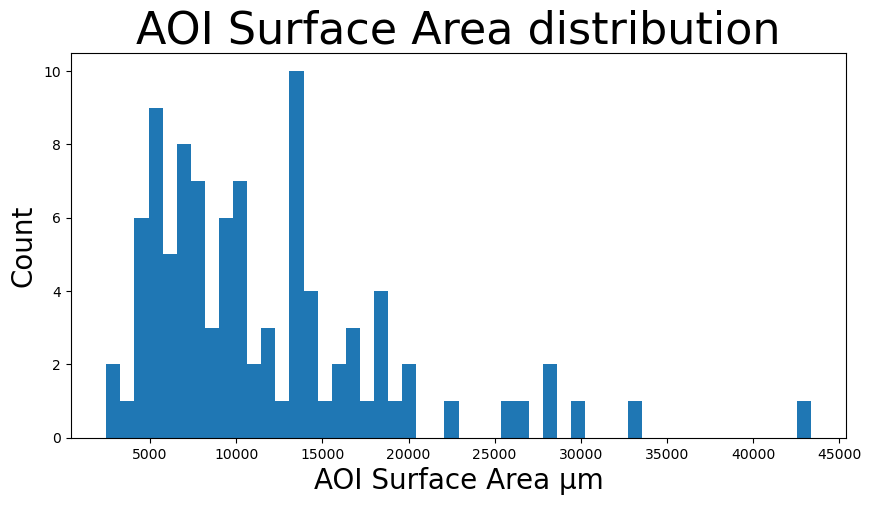

In [48]:
# View distribution of AOI surface areas

#Add colouring for different AOI types

SAHist = plot_SA_Hist(surfArea)
# SAHist.show()

In [ ]:
input("Press Enter to continue and choose factors of interest via the checkboxes generated in the next cell.")

<i>INFO: The input cell does not advance to the next cell. Run the first cell below to generate the checkboxes, then select checkboxes and run the second cell below to read the selected checkboxes. Re-running the first cell below will clear selections and generate empty checkboxes.</i>

In [ ]:
selected_data = []

data = list(sampleInfo.index)
checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
output = widgets.VBox(children=checkboxes)
display(output)

In [ ]:
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        selected_data = selected_data + [checkboxes[i].description]
print(selected_data)


In [ ]:
# selected_data = ['Substrate', 'Diff', 'Size', 'Morphology', 'Day', 'Layer']
selected_data = ['Row', 'Col']

#### factors uniques table

In [ ]:
selectedInfo = sampleInfo.loc[selected_data]

selectedInfo

In [ ]:
# data_df = selectedInfo.stack().groupby(level=0).apply(lambda x: x.unique().tolist())

In [ ]:
data_df = selectedInfo.stack().groupby(level=0).apply(lambda x: x.unique())

data_df

In [ ]:
data_df = pd.DataFrame(data_df).T

In [ ]:
# ToDo: Break lists down into separate rows

In [ ]:
data_df.style.set_table_styles(
                        [{
'selector': 'th',
   'props': [
('background-color', 'black'),
       ('color', 'white'),
       ('border-color', 'black'),
       ('border-style ', 'solid'),
       ('border-width','1px')]  
},
{
   'selector': 'td',
   'props': [
       ('border-color', 'black'),
       ('border-style ', 'solid'),
       ('border-width','1px')]
},
{'selector': '.row_heading',
      'props': [('display', 'none')]},
{'selector': '.blank.level0',
      'props': [('display', 'none')]}])

#### factors unique combinations table

In [ ]:
comboUniques = []
for c in selectedInfo.columns:
    thisCol = selectedInfo[c]
    combined = '_'.join(thisCol.values)
    comboUniques.append(combined)
    # print(combined)

comboUniques = sorted(list(set(comboUniques)))

for x in comboUniques:
    print(x)

print('\nNumber of unique combinations: {}'.format(len(comboUniques)))

#### Choose factrors to use for colour selection in the plots below

In [ ]:
selected_data = []

data = list(selectedInfo.index)
checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
output = widgets.VBox(children=checkboxes)
display(output)

In [ ]:
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        selected_data = selected_data + [checkboxes[i].description]
print(selected_data)


In [ ]:
# selected_data = ['Substrate', 'Diff', 'Morphology', 'Layer']
selected_data = ['Row', 'Col']

In [ ]:
selectedInfo = selectedInfo.loc[selected_data]
selectedInfo

ToDo: Add colour lookup dictionary

In [ ]:
comboUniques = []

# comboColourDict = {}
comboColourDictRev = {}

for c in selectedInfo.columns:
    thisCol = selectedInfo[c]
    combined = '_'.join(thisCol.values)
    comboUniques.append(combined)
    
    # try:
    #     comboColourDict[combined].append(c)
    # except:
    #     comboColourDict[combined] = [c]

    comboColourDictRev[c] = combined

comboUniques = sorted(list(set(comboUniques)))

for x in comboUniques:
    print(x)

print('\nNumber of unique combinations: {}'.format(len(comboUniques)))





In [ ]:
binding_density_plot(sampleInfoExternal, selectedInfo, selected_data)

for s in selected_data:
    binding_density_plot(sampleInfoExternal, selectedInfo, s)
    

In [ ]:
# Visualise basic QC statistics

## Relate back to collection order, and plate/well location

## Binding density

# Visualise raw probe values before any normalisation

In [ ]:
# Sort data by probeclass then mean for nicer visualisation on plots
dataSortedRaw = dataLog1External.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])

probePlot = draw_probe_plot_2(dataLog1External, dataSortedRaw, namedColourList, sampleInfoExternal, selectedInfo, 'Col', 'Raw Probe Values')
probePlot = draw_probe_plot_2(dataLog1External, dataSortedRaw, namedColourList, sampleInfoExternal, selectedInfo, 'Col', 'Raw Probe Values', exp=True)


In [ ]:
plt.scatter(np.exp2(dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['HYB-NEG'])-1,
            dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['HYB-POS'])

In [ ]:
plt.scatter(np.exp2(dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc['HYB-NEG'])-1,
        surfArea.reindex(dataLog1External.drop(labels=['mean','probeClass'],axis=1).columns))

In [ ]:
##### QC questions / checks:

# Determine thresholding value for limit of detection for assay

In [ ]:
## Find the first local minimum closest to the start of the 'real' values.
## In this development case there is a large peak of near zero values, after this there are two bins with zero values. The second of these bin indexes was chosen for use as the expression threshold value.


In [ ]:
thresholding = threshold_probes(dataLog1External, 300)

In [ ]:
thresholding.zoom_plot(0.5,3)

In [ ]:
thresholding.check_threshold(0,20)
thresholding.check_threshold(10,20)

In [ ]:
#Set index value to use for minimum expression threshold from thresholding 
thresholding.set_threshold_idx(13)

In [ ]:
print(thresholding.threshold)
ETFiltered = thresholding.get_filter()

# Plot counts of AOIs and probes passing threshold

In [ ]:


# get counts of how many probes are above the expression threshold for each AOI

In [ ]:
exportPath = dataPath[:dataPath.rfind('/')]

In [ ]:
ETFiltered

In [ ]:
passAOI = ETFiltered.sum()

thisMin = min(passAOI)
thisMax = max(passAOI)
print('thisMin')
print(thisMin)
print('thisMax')
print(thisMax)

plt.hist(passAOI.values, bins=20)
plt.xlim(thisMin-2,thisMax+2)
plt.semilogy()

In [ ]:
passAOI.sort_values().index[:5]

In [ ]:
failAOIs = passAOI[passAOI < 15]

failAOIs

In [ ]:


# writeOutput = True
if writeOutput:
    failAOIs.to_csv(os.path.join(exportPath,'failAOIs.csv'))
# writeOutput= False


In [ ]:
# get counts of how many AOIs are above the expression threshold for each probe

In [ ]:
passProbe = ETFiltered.sum(axis=1)

thisMin = min(passProbe)
thisMax = max(passProbe)
print('thisMin')
print(thisMin)
print('thisMax')
print(thisMax)

plt.hist(passProbe.values, bins=20)
plt.xlim(thisMin-5,thisMax+5)
# plt.semilogy()

In [ ]:
# ToDo: Ask for a value to use for fail probes cutoff

In [ ]:
failProbes = passProbe[passProbe < 70]

failProbes

In [ ]:

# writeOutput = True
if writeOutput:
    failProbes.to_csv(os.path.join(exportPath,'FailProbes.csv'))
# writeOutput= False



In [ ]:
master_data.set_threshold(master_data,ETFiltered)

In [ ]:
master_data.threshold


In [ ]:
# Identify outlier AOIs and probes
# Drop outlier AOIs and probes

In [ ]:
# colours = ['g' if x.split('_')[-1] == 'Tumour' else 'r' if x.split('_')[-1] == 'Immune' else 'purple' for x in data.drop(labels=['mean','probeClass'], axis=1).columns]


# Plot geometric means of negative controls and housekeeping genes in raw data:

In [ ]:
##### It's probably not neccessary to view the following, 
# but lets just have a quick look at how the control values 
# for the raw data is distributed to make sure there are 
# no extreme outliers before ERCC normalisation.

In [ ]:
# Calculate Ig control Geometric mean and Housekeeping gene Geometric mean
# Calculating the mean of log transformed data is analagous to calculating the geometric mean of the non-transformed data

HKGeoMean = dataLog1External.drop(labels=['mean','probeClass'], axis=1).loc[masterData.HK].mean()
HKGeoMean = HKGeoMean.sort_values()


IgGeoMean = dataLog1External.drop(labels=['mean','probeClass'], axis=1).reindex(labels=HKGeoMean.index, axis=1).loc[masterData.IgCTLs].mean()

HKIgCtls = masterData.HK.copy()
HKIgCtls.extend(masterData.IgCTLs)

HKIgCtlGeoMeans = dataLog1External.drop(labels=['mean','probeClass'], axis=1).reindex(labels=HKGeoMean.index, axis=1).loc[HKIgCtls].mean()


In [ ]:
masterData.HK

In [ ]:
HKIgCtls = masterData.HK.copy()

In [ ]:
HKIgCtls.extend(masterData.IgCTLs)

In [ ]:
HKIgCtls

In [ ]:
HKGeoMean

In [ ]:
probe_GeoMean_Plots(HKGeoMean, 'House Keeping probe geometric mean distribution')

probe_GeoMean_Plots(IgGeoMean, 'Ig probe geometric mean distribution')

In [ ]:
probe_GeoMean_Plots(HKIgCtlGeoMeans, 'HK and Ig probe geometric mean distribution')

In [ ]:
HKIgCtls = masterData.HK.extend(masterData.IgCTLs)

In [ ]:
masterData.HK

In [ ]:
#ToDo: make this a copy of the internal dataFrame. Ensure original data is contained in the master class and cannot be changed accidentally from outside of class.

ERCC_normExternal = masterData.ERCC_norm()

In [ ]:
ERCC_normExternal

## Load-in deafult QC data for further data QC

In [ ]:
# configDict['QCDataPath']

In [ ]:
QCmasterData = master_data(os.path.join(configDict['rootDir'],configDict['QCDataPath']))
QCdataLog1External, QCsampleInfoExternal = QCmasterData.get_data()

# For the Thomas TMA study there are a number of additional AOIs to be used for data normalisation studies.
# These should be removed before further data analysis and QC.

print(QCmasterData.probeClass)
print(QCmasterData.probeClassDict)
# dataLog1External, sampleInfoExternal = masterData.drop_AOIs('#16_9', writeOrig=True)

# QCnuclei = QCsampleInfoExternal.loc['AOI nuclei count']
# QCsurfArea = QCsampleInfoExternal.loc['AOI surface area']

QCdataLog1External, QCsampleInfoExternal = QCmasterData.add_class_mean(QCmasterData.dataLog1)

In [ ]:
QCdataLog1External

In [ ]:
# Sort data by probeclass then mean for nicer visualisation on plots
QCdataSortedERCC = QCdataLog1External.sort_values(by = ['probeClass', 'mean'], ascending=[True,True])

# ToDo: repeat the colour map after data sorting

In [ ]:
probePlot = draw_probe_plot(QCdataLog1External, QCdataSortedERCC, namedColourList, 'QC Probe Values')
probePlot = draw_probe_plot(QCdataLog1External, QCdataSortedERCC, namedColourList, 'QC Probe Values', violin=True)

probePlot = draw_probe_plot(QCdataLog1External, QCdataSortedERCC, namedColourList, 'QC Probe Values', exp=True)

### ToDo: Collate figures into a pdf

In [ ]:
QCSortedIndex = sorted(masterData.probeClass.index, key=lambda x: masterData.probeClassDict[masterData.probeClass[x]])

QCSortedIndex

In [ ]:
QCSortedProbes = masterData.probeClass[QCSortedIndex]

In [ ]:
QCSortedProbes.name = "Code.Class"

In [ ]:
QCSortedProbes

In [ ]:
QCExport = QCmasterData.dataOrig.copy()

In [ ]:
posNeg = masterData.dataOrig.loc[['HYB-NEG','HYB-POS'],]

In [ ]:
QCExport = pd.concat([QCExport,posNeg])
QCExport = QCExport.loc[QCSortedIndex,]
QCExport = pd.concat([QCSortedProbes, QCExport], axis = 1)
QCExport.index.name = 'Name'
QCExport

In [ ]:
normDir = os.path.join(configDict['rootDir'], 'DSP_Protein_Data', 'Normalisation')
normDir = os.path.join(configDict['rootDir'], 'Normalisation')

# check if folder exists and create directory if not
if not (os.path.isdir(normDir)):
    os.mkdir(normDir)


In [ ]:
# ToDo: Ask for project name interactively

project = configDict['projectName']
qcCSV = 'QC_' + project + '_RUV.csv'

# writeOutput = True
if writeOutput:
    QCExport.to_csv(os.path.join(normDir, qcCSV))
# writeOutput= False

In [ ]:
normDir

# Run NSNorm in R

In [ ]:
# Rscript Documents/notebooks/Nanostring/Larisa_Spheroids/DSP_EDA_Protein/NSNorm.R -d /Users/upton6/Documents/Nanostring/projects/Larisa/2312_Run/DSP_Protein_Data/Normalisation -f QC_Larisa_Spheroids_RUV.csv

cmd = 'Rscript NSNorm.R -d ' + normDir + ' -f ' + qcCSV
print(cmd)
os.system(cmd)